# Lab 9: Twitter data analysis  

In this lab, we will learn how to read JSON files and how to perform exploratory analysis of twitter data. As an extra credit, you will learn how to use API to download tweets on the topic of your choice.

Let us start by importing the needed packages.

In [1]:
import json
import random
import time
import calendar
import codecs
import datetime
import sys
import gzip
import string
import glob
import os
import numpy as np
import dateutil.parser

## Module 0: Reading Tweets

Tweets are saved in the form of a JSON file. Open `onetweet` file in a text editor and study how it looks. This file contains information from a single tweet. The file is written in the JSON format, which is easy for a computer to read and parse. 

**Question 1**. Google `JSON` and try to learn about this particular data format. Explain in one or two paragraphs what you learned.

JSON stands for JavaScript Object Notation. It is a language independent format, derived from JavaScript. It is a convenient language for exchanging data.  
Let us read `onetweet` JSON file. We will create an object and print it.

In [2]:
from pprint import pprint
tweet = json.load(open('onetweet', 'rb'))
pprint (tweet)

{u'_id': u'264230205529411585',
 u'contributors': None,
 u'coordinates': {u'coordinates': [-73.95639896, 40.71411847],
                  u'type': u'Point'},
 u'created_at': u'2012-11-02T04:59:24',
 u'disaster': u'2012_sandy_hurricane_en',
 u'entities': {u'hashtags': [],
               u'symbols': [],
               u'urls': [{u'display_url': u'instagr.am/p/Rg70o6xlkY/',
                          u'expanded_url': u'http://instagr.am/p/Rg70o6xlkY/',
                          u'indices': [33, 53],
                          u'url': u'http://t.co/G0LdsQAz'}],
               u'user_mentions': []},
 u'favorite_count': 0,
 u'favorited': False,
 u'geo': {u'coordinates': [40.71411847, -73.95639896], u'type': u'Point'},
 u'id': u'264230205529411585',
 u'id_str': u'264230205529411585',
 u'in_reply_to_screen_name': None,
 u'in_reply_to_status_id': None,
 u'in_reply_to_status_id_str': None,
 u'in_reply_to_user_id': None,
 u'in_reply_to_user_id_str': None,
 u'is_quote_status': False,
 u'lang': u'en',

As we can see, each tweet is stored in a dictionary. Although there are more than 20 different keys in the dictionary, we introduce the most important fields which will be used in the rest of this lab.
<ul>
<li>'_id': shows the unique id of this tweet.</li>

<li>'coordinates': shows the location from which the tweet was posted. The field might be null if the tweet contains no location data, or it could contain bounding box information, place information, or GPS coordinates in the form of (longitude, latitude). </li>

<li>'created_at': shows the time the tweet has been created.</li>

<li>'text': shows the text of the tweet.</li>

<li>'user': contains multiple dictionaries describing the user, including the name of this user, the number of followers, the number of friends...</li>
</ul>

**Question 2**. Explain 3 more keys that you find interesting
<ul>

<li>'Possibly_sensitive' is interesting, since it must have an AI algorithm behind.

<li>'retweeted' is obviously interesting

<li>'geo' is also oddly interesting, since it reviews that our location is tracked when we use social media

In the following code we will load around 4,000 tweets sent from New York City region during Sandy Hurricane from a JSON file `myNYC.json`. As part of this process, we will extract each tweet's post time and create a time series of the number of tweets in each hour during the event.

In [6]:
filePath='smallNYC.json'
localTweetList = []
globalTweetCounter = 0
frequencyMap = {}
timeFormat = "%a %b %d %H:%M:%S +0000 %Y"
reader = codecs.getreader("utf-8")
for line in open(filePath, 'rb'):
    # Try to read tweet JSON into object
    tweetObj = None
    tweetObj = json.loads(reader.decode(line)[0])
    
    # Try to extract the time of the tweet
    currentTime=dateutil.parser.parse(tweetObj['created_at'])
    currentTime = currentTime.replace(second=0)
    currentTime = currentTime.replace(minute=0)

    #print currentTime
    # Increment tweet count
    globalTweetCounter += 1
    
    # If our frequency map already has this time, use it, otherwise add
    if ( currentTime in frequencyMap.keys() ):
        timeMap = frequencyMap[currentTime]
        timeMap["count"] += 1
        timeMap["list"].append(tweetObj)
    else:
        frequencyMap[currentTime] = {"count":1, "list":[tweetObj]}

# Fill in any gaps
times = sorted(frequencyMap.keys())
firstTime = times[0]
lastTime = times[-1]
thisTime = firstTime

#timeIntervalStep = datetime.timedelta(0, 60)    # Time step in seconds
timeIntervalStep = datetime.timedelta(hours=1)
while ( thisTime <= lastTime ):
    if ( thisTime not in frequencyMap.keys() ):
        frequencyMap[thisTime] = {"count":0, "list":[]}
        
    thisTime = thisTime + timeIntervalStep

print ("Processed Tweet Count:", globalTweetCounter)

('Processed Tweet Count:', 4295)


## Module 1: Simple Frequency Analysis

In this section, we will cover a few simple analysis techniques for EDA of the available twitter datay.

- Twitter Timeline
- Top Twitter Users
- Twitter API
- Posting Frequency Distribution
- Popular Hashtags
- Simple Event Detection
- Language Distributions

### Twitter Timeline 

To build a timeline of Twitter usage, we can simply plot the number of tweets posted per hour.

('Time Frame:', datetime.datetime(2012, 10, 22, 5, 0), datetime.datetime(2012, 11, 2, 4, 0))


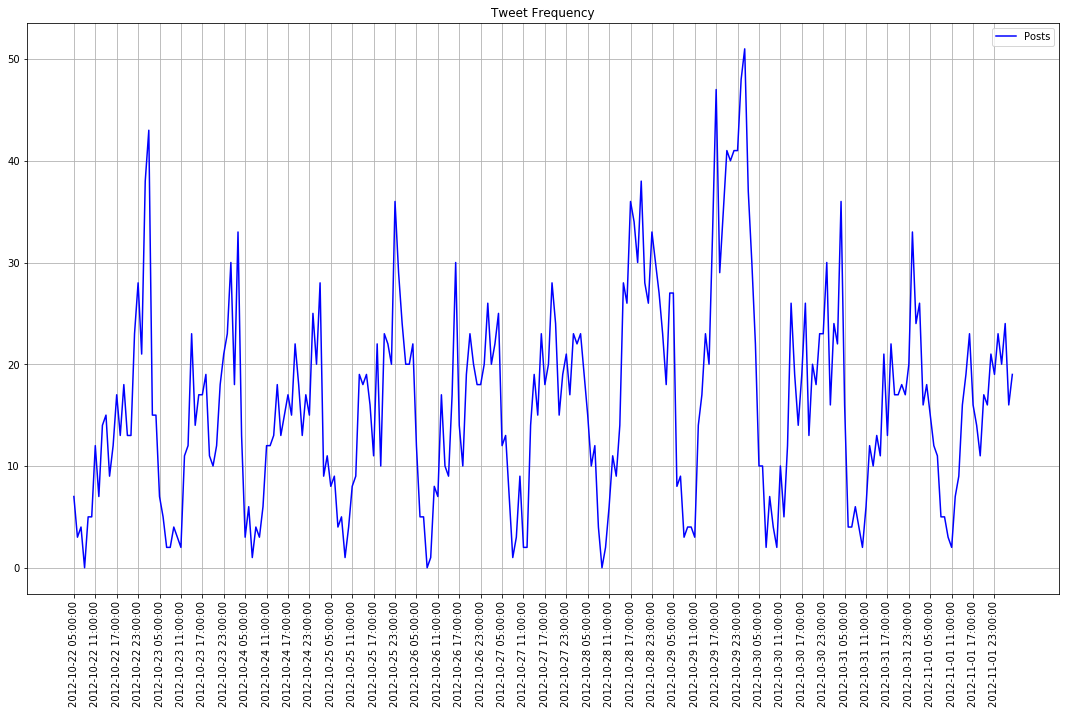

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
fig.set_size_inches(18.5,10.5)

plt.title("Tweet Frequency")

# Sort the times into an array for future use
sortedTimes = sorted(frequencyMap.keys())

# What time span do these tweets cover?
print ("Time Frame:", sortedTimes[0], sortedTimes[-1])

# Get a count of tweets per minute
postFreqList = [frequencyMap[x]["count"] for x in sortedTimes]

# We'll have ticks every thirty minutes (much more clutters the graph)
smallerXTicks = range(0, len(sortedTimes), 6)
plt.xticks(smallerXTicks, [sortedTimes[x] for x in smallerXTicks], rotation=90)

# Plot the post frequency
ax.plot(range(len(frequencyMap)), [x if x > 0 else 0 for x in postFreqList], color="blue", label="Posts")
ax.grid(b=True, which=u'major')
ax.legend()

plt.show()

**Question 3**. When is the tweeting activity the largest? Find a wikipedia article about the Sandy Hurricane to understand the timeline of events surrounding it. Discuss if you see a correlation with the tweet frequencies. Select some tweets from different time points and see if the messages are correlated with the events on the ground.

**Q3 answer:**
The tweet activity is largest between 11:00 in 2012-10-29 to 5:00 of 2012-10-29. This makes sense as this is the time that the storm hits land

In [46]:
high1 = datetime.datetime(2012, 10, 29, 23, 0)
high2 = datetime.datetime(2012, 10, 29, 17, 0)
low1 = datetime.datetime(2012, 10, 23, 23, 0)
for i in frequencyMap[low1]['list']:
    print i['text']
#The tweets are, as expected, not about the storms but about some other 'interesting' subjects...

#IAdmitThat I'm addicted to gummy bear :)
Classy bar night for @OxheartNYC (@ Trump Tower Plaza) [pic]: http://t.co/gtIiAoa6
Fillin out these job app somthin gotta give !
Crazy crazy day @ Time Life http://t.co/BjtG7esp
Drunk laundry (@ Parsons Ale House) http://t.co/3HOMeFzO
@_BbySkoob # ?
@ThatGirl_Candy okay fine then :'(
@Tony_2_Fingers k I might come again
@janessamingolo just have a gay friend
Its on like donkey kong boyyy he said you're mamma cant read! Her illiterate ass 😱😱😱
@JayNellyBeans :-D
I like when girls come and request "bands to make her dance" they about it lol
at @gwalumni alumni event in NYC about health care &amp; #Obamacare #GW  @ Waldorf-Astoria Hotel http://t.co/p0n4rIrV
Art + Beats + Lyrics event courtesy of the Gentleman Jack Daniels 🍷 @ 404 http://t.co/2gHM8eQ3
Admin Alert planning Resources for Minogue of those Notary. http://t.co/yrbbHms2
@MILKALAMASDURA en rabia.
Cougar lady with the shiny crocodile skin jacket, the pimp from the 70's wants his jacket back

In [48]:
for i in frequencyMap[high2]['list']:
    print i['text']
#The tweets are about people panicking about the storm #HurricaneSandy

Battery Park zojuist afgesloten. Op naar Wall Street. #SVJgoesUSA #Sandy
@rayraydel @meredi Not to minimize it but at the end of 2nd St the canal is usually only about 1/2 foot below the edge
You know it's an ancient episode of sec and the city when they're smoking in a bar
@xox_ShayShining lmao name a time?
If I'm ever rich, I'm going to have a bookshelf that is a revolving door into a secret room. #ThoughtsWhileRidingOutHurricaneSandy
On charger right now: 1. Phone 2. Laptop 3. iPod 4. iPod 5. Other Phone Not taking any chances lmao -- Daniel Ezomo (@situation827)  READY
@SukanyaNYC Thanks for your coverage, today.  be safe... XXOO
Ojalá el pais entero.  Se conmoviera de caso colmenares. Y volcó rieran esas entidades de corrupción. Q triste. Ese sistema. De justicia.
@Maxgschneider aren't you still in Canada? Just in case you're not be safe &lt;3
@FrancisJimenezC todavía nose exactamente me gustaría pa'el carnaval que nunca eh ido,o pa' Enero pa' q me lleve a las patronales d Loma lo

In [49]:
for i in frequencyMap[high1]['list']:
    print i['text']
#They are all about the storm

RT @Brie: You can see the whole place inside! http://t.co/AN5ziKzo
Oh, btw Fuck you #sandy I need my vacation already. (@ Frankenstorm Apocalypse - Hurricane Sandy w/ @bohan) http://t.co/4keVVwCX
and now all the building around us are without light, it's scary, all Wall Street is black and dark
Water rising on the street below @ Newport Boardwalk http://t.co/mdxzgQrF
@camilourbano Se ve super bien. Tengo que ser más juicioso y ponerme al día. Gracias.
Wind, sirens and Park bitching has been the soundtrack to my day #sandy
All these "I hope you can swim" and "don't die" texts are really nice guys....
This is the last thing I needed right now is no damn lights ...smdh
Actual photo of sandy approaching manhattan. http://t.co/xzwZHiR7
@nateleo_TL you can come here I never lose power 😊😛
@BBCNews #sandy playing bingo with dry beans at Holiday Inn 57th st NYC. On lockdown due to storm http://t.co/jO51gzGl
All we have been doing is eating... Not good.
@TatyV2 i know lol
if anyone else is bored

### Top Twitter Users

The following piece of code reveals the users that produced the most tweets. 

In [51]:
# Create maps for holding counts and tweets for each user
globalUserCounter = {}
globalUserMap = {}

# Iterate through the time stamps
for t in sortedTimes:
    timeObj = frequencyMap[t]
    
    # For each tweet, pull the screen name and add it to the list
    for tweet in timeObj["list"]:
        user = tweet["user"]["screen_name"]
        
        if ( user not in globalUserCounter ):
            globalUserCounter[user] = 1
            globalUserMap[user] = [tweet]
        else:
            globalUserCounter[user] += 1
            globalUserMap[user].append(tweet)

print ("Unique Users:", len(globalUserCounter.keys()))

('Unique Users:', 3017)


In [8]:
sortedUsers = sorted(globalUserCounter, key=globalUserCounter.get, reverse=True)
print ("Top Ten Most Prolific Users:")
for u in sortedUsers[:10]:
    print (u, globalUserCounter[u], "\n\t", "Random Tweet:", globalUserMap[u][0]["text"], "\n----------")

Top Ten Most Prolific Users:
(u'Young_Boss718', 37, '\n\t', 'Random Tweet:', u'That random text  I had got be for LMFAO shit was funny', '\n----------')
(u'Cocky_Johnny', 15, '\n\t', 'Random Tweet:', u'@_tinaDeex3 LMAO #Dead', '\n----------')
(u'frankieciv608', 15, '\n\t', 'Random Tweet:', u'\u201c@JohnKincade Dear Donald Trump,\nAmericans &amp; Republicans chose to not involve you in this election between Prez &amp; Romney.\nPlease go away.\u201d', '\n----------')
(u'labroides', 14, '\n\t', 'Random Tweet:', u"@SharkDevocean best of luck. That's awesome", '\n----------')
(u'ReelTalker', 12, '\n\t', 'Random Tweet:', u'@FilmFatale_NYC also, in other news, i totally thought it was idris who tweeted me. Saw the pic and got  excited :-)', '\n----------')
(u'kcastrox3', 11, '\n\t', 'Random Tweet:', u'Cuz this love is a sure thing.', '\n----------')
(u'carolsommers727', 11, '\n\t', 'Random Tweet:', u'@coreymach lookin spiffy \U0001f44c', '\n----------')
(u'Amooniac', 11, '\n\t', 'Random Tweet

**Question 4**. Find and print the top 10 users with the most friends. Find and print the top 10 users with the most followers. 

In [92]:
#Most friends

most_friends = {}
most_followers = {}
for t in sortedTimes:
    timeObj = frequencyMap[t]
    
    # For each tweet, pull the screen name and add it to the list
    for tweet in timeObj["list"]:
        user = tweet["user"]["screen_name"]
        friends = tweet['user']['friends_count']
        followers = tweet['user']['followers_count']
        if ( user not in most_friends ):
            most_friends[user] = friends
        if( user not in most_followers):
            most_followers[user] = followers





In [69]:
friends_view = [ (v,k) for k,v in most_friends.iteritems() ]
friends_view.sort(reverse=True) # natively sort tuples by first element
i = 0
print "Top Ten Most Friends Users: "
for v,k in friends_view:
    print "%s: %d" % (k,v)
    i+= 1
    if i == 10:
        break;


Top Ten Most Friends Users: 
mstupenengo: 49501
GinsburgJobs: 49441
WeAreJocelyn: 37969
MrThugZilla2K15: 33902
davesurber: 29221
55_althani: 26414
EddieJMontanez: 21662
andrewcotto: 17312
MargaretMolloy: 16958
tupaclivesss: 11334


In [95]:
followers_view = [ (v,k) for k,v in most_followers.iteritems() ]
followers_view.sort(reverse=True) # natively sort tuples by first element
j = 0
print "Top Ten Most Followed Users: "
for v,k in followers_view:
    print "%s: %d" % (k,v)
    j+= 1
    if j == 10:
        break;


Top Ten Most Followed Users: 
mstupenengo: 1162644
iJokes_: 185923
felixsalmon: 164709
EmersonOverton: 155045
AgramyQ8: 112323
55_althani: 94191
QueensMuseum: 80871
JosephWakile: 73103
Majovargas_: 67256
GinsburgJobs: 64527


### Distribution of Postings

It appears a few users were posting to Twitter a lot. But how often did most Twitter users tweet during this time? We can build a histogram to see this distribution.


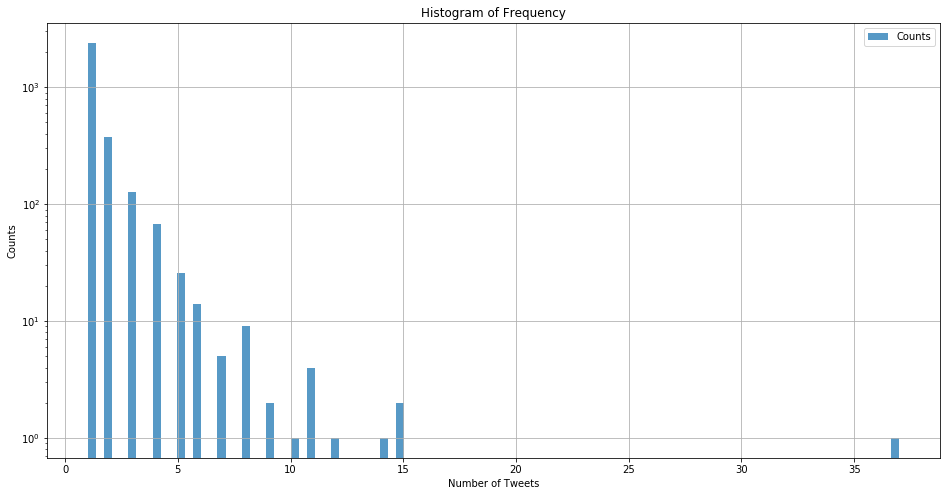

In [9]:
plt.figure(figsize=(16,8))
    
# the histogram of the data
plt.hist(
    [globalUserCounter[x] for x in globalUserCounter], 
    bins=100, 
    normed=0, 
    alpha=0.75,
    label="Counts",
    log=True)

plt.xlabel('Number of Tweets')
plt.ylabel('Counts')
plt.title("Histogram of Frequency")
plt.grid(True)
plt.legend()

plt.show()

**Question 5**. Study 3 users with the most posts. What were they tweeting about?

### Average Number of Posts

In [10]:
avgPostCount = np.mean([globalUserCounter[x] for x in globalUserCounter])
print("Average Number of Posts:", avgPostCount)

('Average Number of Posts:', 1.4119000657462195)


**Q5: **


In [103]:
for u in sortedUsers[:3]:
    print 'USER: ' + str(u)
    for x in globalUserMap[u]:
        print x['text']
        
    print ""


USER: Young_Boss718
That random text  I had got be for LMFAO shit was funny
@MeerGotGame don't try and find shit lol
U inbox her on fb or text her
That wax museum is a fool in New York shit be real af
I kinda just felt when she just said idgaf lol
We be on the loud shit
Y'all be smoking that low volume
@BossBitchShxt chill out Monae you know I fucks with fab lol
I got my list tho 🙈🙉🙊
@The_Good_Fella9 it's ok
@NOFcks_Givn gave that head to ?
PART2
@The_Good_Fella9 word she's cool af
i wonder who had crush on me on twitter 😜😝😛😵
White girls don't have butts LMFAO
@BricksFromPluto lol
@SugarCocaine_ well I heard mad down south ppl say it that's why I ask
Getting alil sleepy
Moms gone for the whole night shit just about to smoke &amp; kick it with da homies
@LiyahhDoeee I know that's not you in them heels and skirt
@MikeyGotBudd I fucks with the mishka shirt fam
@Loud_Everyday 💯 already know
@She_Suckedd nigga shut up 😒
The pic jaida just posted -_-
No more talking, let’s be about it
Sexcap

They don't seem to be talking about the storm but instead some other trivial topics...

### Popular Hashtags

Hashtags give us a quick way to view the conversation and see what people are discussing. Getting the most popular hashtags is just as easy as getting the most prolific users.


In [11]:
# A map for hashtag counts
hashtagCounter = {}

# For each minute, pull the list of hashtags and add to the counter
for t in sortedTimes:
    timeObj = frequencyMap[t]
    
    for tweet in timeObj["list"]:
        hashtagList = tweet["entities"]["hashtags"]
        
        for hashtagObj in hashtagList:
            
            # We lowercase the hashtag to avoid duplicates (e.g., #MikeBrown vs. #mikebrown)
            hashtagString = hashtagObj["text"].lower()
            
            if ( hashtagString not in hashtagCounter ):
                hashtagCounter[hashtagString] = 1
            else:
                hashtagCounter[hashtagString] += 1

print ("Unique Hashtags:", len(hashtagCounter.keys()))
sortedHashtags = sorted(hashtagCounter, key=hashtagCounter.get, reverse=True)
print ("Top Twenty Hashtags:")
for ht in sortedHashtags[:20]:
    print ("\t", "#" + ht, hashtagCounter[ht])

('Unique Hashtags:', 997)
Top Twenty Hashtags:
('\t', u'#sandy', 108)
('\t', u'#nyc', 47)
('\t', u'#hurricanesandy', 26)
('\t', u'#newyork', 12)
('\t', u'#brooklyn', 9)
('\t', u'#hurricane', 8)
('\t', u'#halloween', 8)
('\t', u'#photooftheday', 8)
('\t', u'#frankenstorm', 8)
('\t', u'#instagood', 8)
('\t', u'#centralpark', 7)
('\t', u'#debates', 6)
('\t', u'#satstudytime', 6)
('\t', u'#instamood', 6)
('\t', u'#100thingsaboutme', 5)
('\t', u'#newyorkcity', 5)
('\t', u'#instagramhub', 5)
('\t', u'#igers', 5)
('\t', u'#instadaily', 5)
('\t', u'#studyingforthesat', 5)


### Event Detection w/ Keyword Frequency

Twitter is good for breaking news. When an impactful event occurs, we often see a spike on Twitter of the usage of a related keyword. Some examples are below.


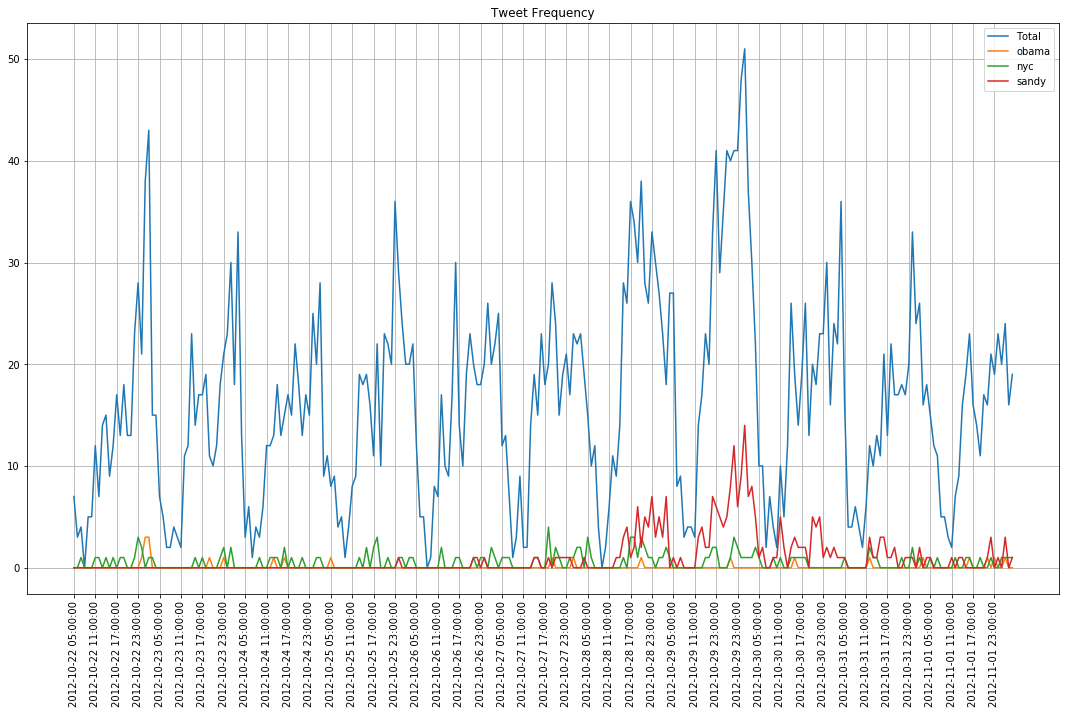

In [106]:
# What keywords are we interested in?
targetKeywords = ["obama", "nyc"]
# targetKeywords.append("lowery")
# targetKeywords.append("reilly")
targetKeywords.append("sandy")

# Build an empty map for each keyword we are seaching for
targetCounts = {x:[] for x in targetKeywords}
totalCount = []

# For each minute, pull the tweet text and search for the keywords we want
for t in sortedTimes:
    timeObj = frequencyMap[t]
    
    # Temporary counter for this minute
    localTargetCounts = {x:0 for x in targetKeywords}
    localTotalCount = 0
    
    for tweetObj in timeObj["list"]:
        tweetString = tweetObj["text"].lower()

        localTotalCount += 1
        
        # Add to the counter if the target keyword is in this tweet
        for keyword in targetKeywords:
            if ( keyword in tweetString ):
                localTargetCounts[keyword] += 1
                
    # Add the counts for this minute to the main counter
    totalCount.append(localTotalCount)
    for keyword in targetKeywords:
        targetCounts[keyword].append(localTargetCounts[keyword])
        
# Now plot the total frequency and frequency of each keyword
fig, ax = plt.subplots()
fig.set_size_inches(18.5,10.5)

plt.title("Tweet Frequency")
plt.xticks(smallerXTicks, [sortedTimes[x] for x in smallerXTicks], rotation=90)

ax.plot(range(len(frequencyMap)), totalCount, label="Total")


for keyword in targetKeywords:
    ax.plot(range(len(frequencyMap)), targetCounts[keyword], label=keyword)
ax.legend()
ax.grid(b=True, which=u'major')

plt.show()

**Question 6**. Study some example codes with 2 different hashtags. Explain how are those messages different. 
 

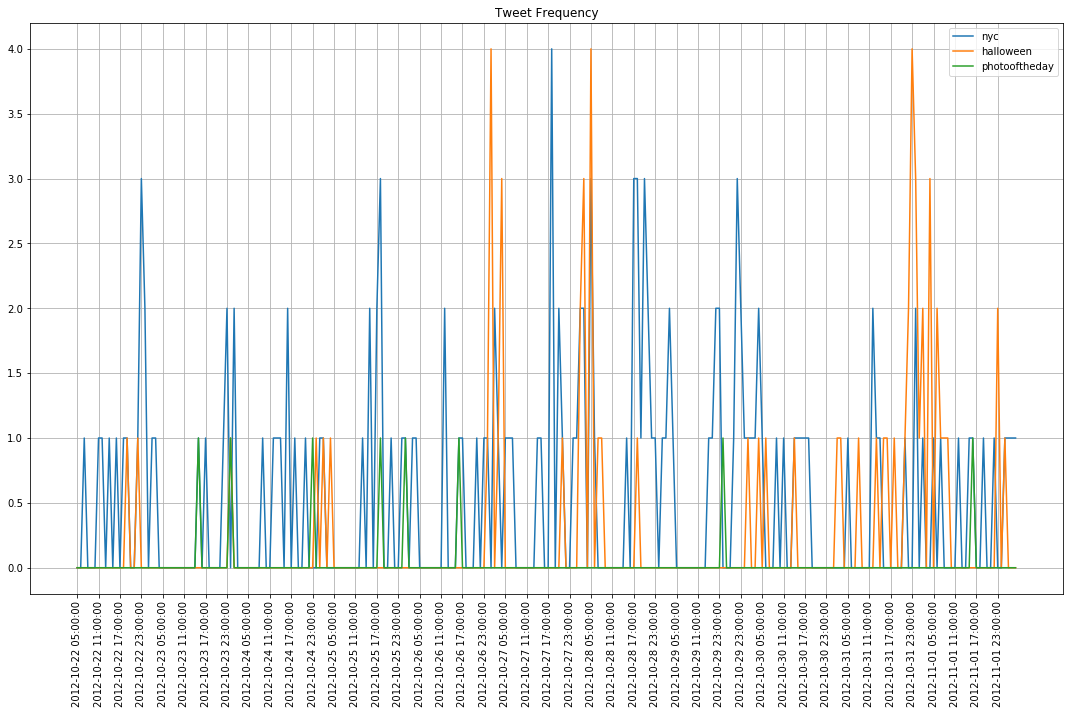

In [115]:
# What keywords are we interested in?
targetKeywords = ["nyc", "halloween",'photooftheday']
# targetKeywords.append("lowery")
# targetKeywords.append("reilly")
#targetKeywords.append("instagood")

# Build an empty map for each keyword we are seaching for
targetCounts = {x:[] for x in targetKeywords}
totalCount = []

# For each minute, pull the tweet text and search for the keywords we want
for t in sortedTimes:
    timeObj = frequencyMap[t]
    
    # Temporary counter for this minute
    localTargetCounts = {x:0 for x in targetKeywords}
    localTotalCount = 0
    
    for tweetObj in timeObj["list"]:
        tweetString = tweetObj["text"].lower()

        localTotalCount += 1 #counts number of tweets
        
        # Add to the counter if the target keyword is in this tweet
        for keyword in targetKeywords:
            if ( keyword in tweetString ):
                localTargetCounts[keyword] += 1
                
    # Add the counts for this minute to the main counter
    totalCount.append(localTotalCount)
    for keyword in targetKeywords:
        targetCounts[keyword].append(localTargetCounts[keyword])
        
# Now plot the total frequency and frequency of each keyword
fig, ax = plt.subplots()
fig.set_size_inches(18.5,10.5)

plt.title("Tweet Frequency")
plt.xticks(smallerXTicks, [sortedTimes[x] for x in smallerXTicks], rotation=90)

#ax.plot(range(len(frequencyMap)), totalCount, label="Total")


for keyword in targetKeywords:
    ax.plot(range(len(frequencyMap)), targetCounts[keyword], label=keyword)
ax.legend()
ax.grid(b=True, which=u'major')

plt.show()

**Since the hashtags I chose are the generic ones that can be used anyday, the fluctuation here is wild**

**Question 7**. Which among the top 20 hashtags are related to Sandy. What are the most popular non-Sandy hashtags?

** In the list, the related hashtags to sandy are 'hurricanesandy', 'hurricane', 'frankenstorm'. The most popular but are unrelated are 'nyc', 'newyork', and 'brooklyn'**

**Question 8**. Among the top 20 hashtags, try to find which of them were particularly popular before Sandy, during Sandy, and those whose popularity did not change much. Try to apply k-means clustering on the time series of hashtags to try to find similar groups of hashtags. Discuss your findings.

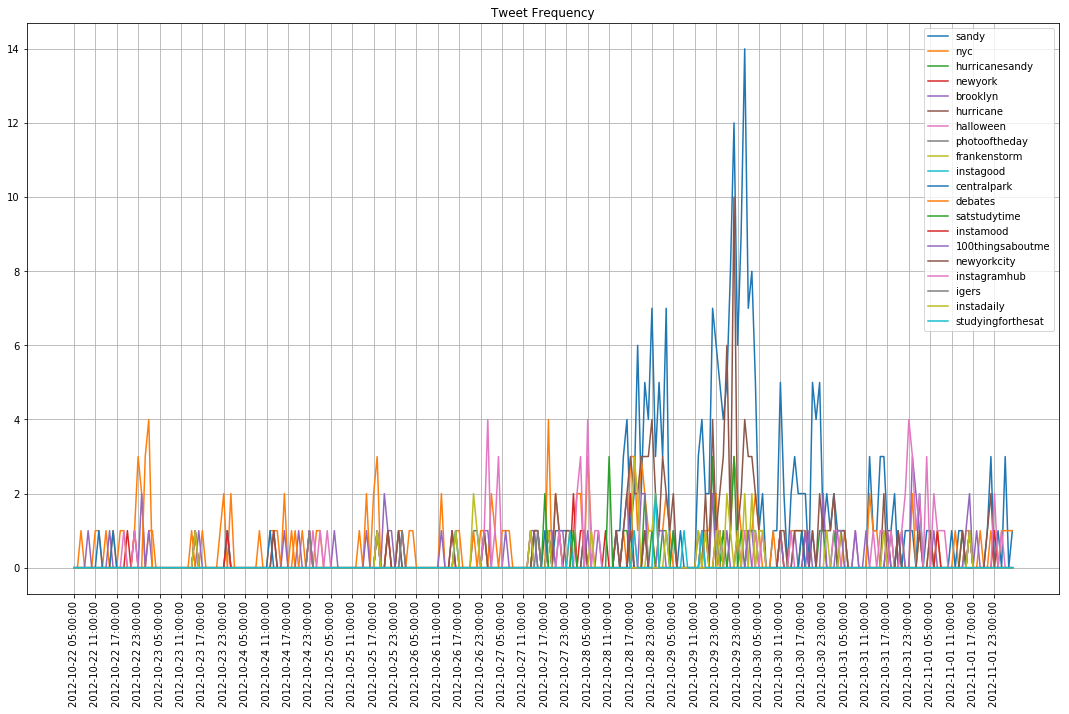

In [141]:
top20 = sortedHashtags[:20]
# What keywords are we interested in?
targetKeywords = top20
# targetKeywords.append("lowery")
# targetKeywords.append("reilly")
#targetKeywords.append("instagood")

# Build an empty map for each keyword we are seaching for
targetCounts = {x:[] for x in targetKeywords}
totalCount = []

# For each minute, pull the tweet text and search for the keywords we want
for t in sortedTimes:
    timeObj = frequencyMap[t]
    
    # Temporary counter for this minute
    localTargetCounts = {x:0 for x in targetKeywords}
    localTotalCount = 0
    
    for tweetObj in timeObj["list"]:
        tweetString = tweetObj["text"].lower()

        localTotalCount += 1 #counts number of tweets at a particular time
        
        # Add to the counter if the target keyword is in this tweet
        for keyword in targetKeywords:
            if ( keyword in tweetString ):
                localTargetCounts[keyword] += 1
                
    # Add the counts for this minute to the main counter
    totalCount.append(localTotalCount)
    for keyword in targetKeywords:
        targetCounts[keyword].append(localTargetCounts[keyword])
        
# Now plot the total frequency and frequency of each keyword
fig, ax = plt.subplots()
fig.set_size_inches(18.5,10.5)

plt.title("Tweet Frequency")
plt.xticks(smallerXTicks, [sortedTimes[x] for x in smallerXTicks], rotation=90)

#ax.plot(range(len(frequencyMap)), totalCount, label="Total")


for keyword in targetKeywords:
    ax.plot(range(len(frequencyMap)), targetCounts[keyword], label=keyword)
ax.legend()
ax.grid(b=True, which=u'major')

plt.show()

**Based on the figure above, it appears that before hurricane sandy, nyc is the most tweeted. But let's just check with data**

In [139]:
df = pd.DataFrame(targetCounts, index = sortedTimes)
df.iloc[:150].sum().sort_values(ascending = False)

nyc                  77
brooklyn             28
halloween            27
sandy                13
hurricane            12
newyork              11
debates               9
frankenstorm          7
instagood             6
photooftheday         6
igers                 4
centralpark           4
instamood             4
satstudytime          3
instagramhub          3
instadaily            3
hurricanesandy        2
newyorkcity           2
studyingforthesat     0
100thingsaboutme      0
dtype: int64

**Indeed, NYC is the most tweeted hashtag. Now, for k-means clustering**

In [142]:
from sklearn.cluster import KMeans

In [191]:
df.T.head() #Need to take the transpose for kmeans

,2012-10-22 05:00:00,2012-10-22 06:00:00,2012-10-22 07:00:00,2012-10-22 08:00:00,2012-10-22 09:00:00,2012-10-22 10:00:00,2012-10-22 11:00:00,2012-10-22 12:00:00,2012-10-22 13:00:00,2012-10-22 14:00:00,...,2012-11-01 19:00:00,2012-11-01 20:00:00,2012-11-01 21:00:00,2012-11-01 22:00:00,2012-11-01 23:00:00,2012-11-02 00:00:00,2012-11-02 01:00:00,2012-11-02 02:00:00,2012-11-02 03:00:00,2012-11-02 04:00:00
100thingsaboutme,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
brooklyn,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
centralpark,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
debates,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
frankenstorm,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [196]:
d = df.T
d.sum(axis = 1)

100thingsaboutme       5
brooklyn              65
centralpark            7
debates                9
frankenstorm          33
halloween             63
hurricane            118
hurricanesandy        28
igers                  6
instadaily             5
instagood              8
instagramhub           5
instamood              6
newyork               24
newyorkcity            5
nyc                  143
photooftheday          8
sandy                256
satstudytime           6
studyingforthesat      5
dtype: int64

In [195]:

labels = df.T.index


kmeans = KMeans(init='k-means++', n_clusters=2, n_init=10)
kmeans.fit(df.T)
pred_classes = kmeans.predict(df.T)

for cluster in range(2):
    print 'cluster: ', cluster
    print labels[np.where(pred_classes == cluster)].tolist()
    print 


cluster:  0
[u'100thingsaboutme', u'brooklyn', u'centralpark', u'debates', u'frankenstorm', u'halloween', u'hurricanesandy', u'igers', u'instadaily', u'instagood', u'instagramhub', u'instamood', u'newyork', u'newyorkcity', u'nyc', u'photooftheday', u'satstudytime', u'studyingforthesat']

cluster:  1
[u'hurricane', u'sandy']



**Using a very simple k-means with k = 2, we can see that 'hurricane' and 'sandy' is in one distinct group, while the rest is in another. This group distribution is not perfect, since 'hurricanesandy' is still in the other group, but overall, I think kmeans did a pretty good job**

### Language Distribution

The following code gives an insight into the languages used for the tweets in your data.


In [13]:
# A map for counting each language
languageCounter = {}

for t in sortedTimes:
    timeObj = frequencyMap[t]
    
    for tweet in timeObj["list"]:
        lang = tweet["lang"]
        
        if ( lang not in languageCounter ):
            languageCounter[lang] = 1
        else:
            languageCounter[lang] += 1
            
languages = sorted(languageCounter.keys(), key=languageCounter.get, reverse=True)

for l in languages:
    print (l, languageCounter[l])

(u'en', 3688)
(u'es', 192)
(u'und', 162)
(u'tl', 29)
(u'fr', 27)
(u'pt', 24)
(u'ar', 20)
(u'tr', 20)
(u'ht', 20)
(u'ru', 18)
(u'it', 16)
(u'in', 16)
(u'nl', 6)
(u'de', 6)
(u'ja', 6)
(u'sv', 5)
(u'pl', 4)
(u'fi', 4)
(u'ko', 4)
(u'lv', 3)
(u'ro', 3)
(u'hi', 3)
(u'vi', 2)
(u'is', 2)
(u'cy', 2)
(u'cs', 2)
(u'et', 2)
(u'da', 2)
(u'sl', 2)
(u'zh', 1)
(u'eu', 1)
(u'lt', 1)
(u'fa', 1)
(u'hu', 1)


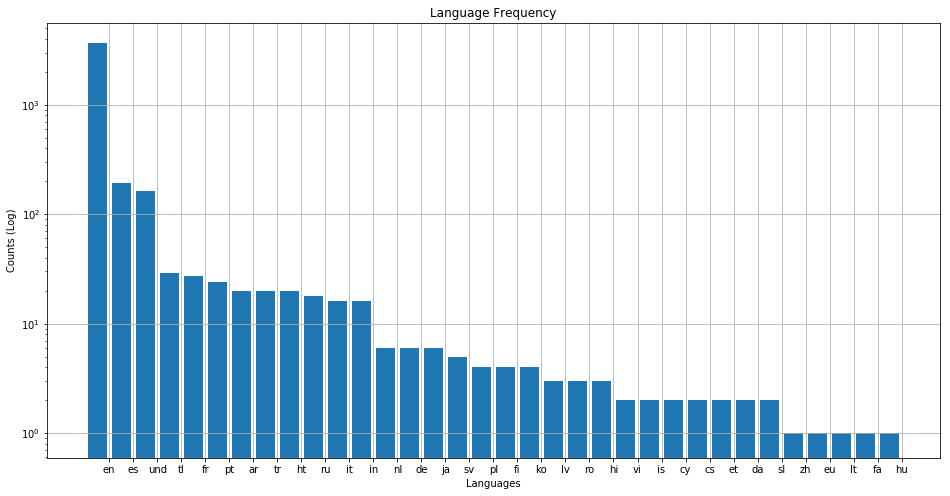

In [14]:
plt.figure(figsize=(16,8))
    
# the histogram of the data
plt.bar(
    np.arange(len(languages)),
    [languageCounter[x] for x in languages],
    log=True)

plt.xticks(np.arange(len(languages)) + 0.5, languages)
plt.xlabel('Languages')
plt.ylabel('Counts (Log)')
plt.title("Language Frequency")
plt.grid(True)

plt.show()

**Quesiton 9**. Now that you have experience in extracting different types of information from twitter data, perform your own EDA. Produce a 1-page report providing some interesting insights about the Sandy twitter data.

## Module 2: Classification

In this part of the lab, we will work on a binary classificaiton problem. In particular, we would like to see how easy it is to discriminate between tweets with hashtag #sandy and the rest of them. To do it, we will first create labels: positive tweets will be those with hashtag #sandy and negative those without the hashtag. Then, we we will create a bag-of-words vector out of each tweet, but we will exclude word "#sandy". To produce the bag-of-words representation we will use the `CountVectorizer` functionality 

In [197]:
import pandas as pd
import numpy as np
import codecs, json

"""
Step 1. Create sentences and labels from json file. 
"""
filePath='smallNYC.json'
sents = []
reader = codecs.getreader("utf-8")
for line in open(filePath, 'rb'):
    # Try to read tweet JSON into object
    tweetObj = None
    tweetObj = json.loads(reader.decode(line)[0])
    sents.append(tweetObj['text'])
    
"""
Step 2.1. Get label. If sent contains '#sandy', label=1; otherwise, label=0
"""
labels = np.array(['#sandy' in sent.split() for sent in sents], dtype='int')
print(pd.Series(labels).value_counts())
"""
Step 2.2. Represent the data into Bag-of-words features, i.e, each sentence is a 
            vector of word counts. 
          a). Only select words with frequency >= 5
          b). Remove label words '#sandy'
"""

from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=5, stop_words = ['#sandy'])
features = vectorizer.fit_transform(sents)


print('#sandy' in vectorizer.get_feature_names())
print(features.toarray())
print(vectorizer.get_feature_names())

0    4234
1      61
dtype: int64
False
[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]
[u'00', u'10', u'100thingsaboutme', u'12', u'13', u'14', u'15', u'16', u'18', u'20', u'2012', u'21', u'24', u'26', u'28', u'2nd', u'30', u'40', u'50', u'6th', u'able', u'about', u'actually', u'ads', u'adventure', u'af', u'after', u'afternoon', u'again', u'against', u'ago', u'ain', u'air', u'airport', u'al', u'album', u'alert', u'alive', u'all', u'almost', u'already', u'also', u'always', u'am', u'amazing', u'america', u'american', u'amp', u'an', u'and', u'another', u'any', u'anyone', u'anything', u'anyway', u'apartment', u'apocalypse', u'app', u'apple', u'appreciate', u'aqui', u'are', u'area', u'aren', u'around', u'art', u'as', u'ask', u'asked', u'asleep', u'ass', u'astoria', u'at', u'ave', u'avenue', u'away', u'awesome', u'awkward', u'aww', u'awww', u'babe', u'baby', u'back', u'bacon', u'bad', u'ballroom', u'bar', u'barcl

**Quesiton 10**. Given the data set of labeled tweets, you have to train a classification model and check the accuracy. Remember to first split the data into training and test. You should explore kNN classification, decision tree classification, Random Forest classification.

**Question 11**. Train the so-called *Logistic regression classifier* and check its accuracy. Compare with the results from *Question 10*. The following lines of code will be useful to do it.

**Question  10: **

In [201]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.33, random_state=42) 
import time
from sklearn.metrics import accuracy_score, roc_auc_score, auc

In [203]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [205]:
rf = RandomForestClassifier()
start_time = time.time()
rf.fit(X_train,y_train)
print('Time for %s fitting: %.3f' % ('Random Forest Classifier', time.time() - start_time))
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
y_pred_prob = rf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob)
print('Test Perf ACC: %.3f, AUC: %.3f' %(accuracy, auc))

Time for Random Forest Classifier fitting: 0.385
Test Perf ACC: 0.989, AUC: 0.762


In [213]:
gb = GradientBoostingClassifier()
start_time = time.time()
gb.fit(X_train,y_train)
print('Time for %s fitting: %.3f' % ('Gradient Boosting', time.time() - start_time))
y_pred = gb.predict(X_test.toarray())
accuracy = accuracy_score(y_test, y_pred)
y_pred_prob = gb.predict_proba(X_test.toarray())[:, 1]
auc = roc_auc_score(y_test, y_pred_prob)
print('Test Perf ACC: %.3f, AUC: %.3f' %(accuracy, auc))

Time for Gradient Boosting fitting: 0.411
Test Perf ACC: 0.986, AUC: 0.986


In [214]:
"""
Step 3. Divide data into train and test 
"""

clf = LogisticRegression()
start_time = time.time()
clf.fit(X_train, y_train)
print('Time for %s fitting: %.3f' % ('LogisticRegression', time.time() - start_time))
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

y_pred_prob = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob)
print('Test Perf ACC: %.3f, AUC: %.3f' %(accuracy, auc))

Time for LogisticRegression fitting: 0.703
Test Perf ACC: 0.988, AUC: 0.986


# Module 3. Extra Credit: Using API to Download Tweets (50 extra points)

To run the following code you will need to install the `tweepy` package.

* Create a twitter account if you do not already have one
* Go to https://apps.twitter.com/ and log in with your twitter credentials.
* Click 'Create New App'
* Fill out the Name, Description, Website fields and agree the terms. Put in any website you want if you don't have one you want to use.
* On the next page, click the 'Keys and Access Tokens' tab along the top, then scroll all the way down until you see the section 'Your Access Token
* Click the button 'Create My Access Token'.
* You will now copy four values below. These values are your 'Consumer Key (API Key)', your 'Consumer Secret (API Secret)', your 'Access token' and your 'Access token secret'. All four should now be visible on the 'Keys and Access Tokens' page. Set the variables corresponding to the API key, API secret, access token, and access secret. You will see code like the below:


In [216]:
!pip install tweepy

  Running setup.py bdist_wheel for PySocks: started
  Running setup.py bdist_wheel for PySocks: finished with status 'done'
  Stored in directory: C:\Users\phongtheha\AppData\Local\pip\Cache\wheels\77\f0\00\52f304b7dddcca8fca05ad1226382134ad50ba6c1662d7539e
  Running setup.py bdist_wheel for win-inet-pton: started
  Running setup.py bdist_wheel for win-inet-pton: finished with status 'done'
  Stored in directory: C:\Users\phongtheha\AppData\Local\pip\Cache\wheels\a5\7d\5d\5488e84ec3f64ed0691dfc8a926e6020423d8980cabe7b4410
Successfully built PySocks win-inet-pton


You are using pip version 9.0.1, however version 9.0.3 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [220]:

from tweepy import Stream
from tweepy import OAuthHandler
from tweepy.streaming import StreamListener
import json, sys
import codecs



ckey = "EX5mens3ZLbhIvR0sbb1EBUat"
csecret = "XUjVmSZ5X8zwbWSAjyiSZh3XP56MlEsAliMYUbKe0awv9xtxYv"
atoken = "826943749-GfHz0cYHLucN7lFqj54kvX6b8NgwgiGjfEy4b8co"
asecret = "W0hTwBNnqs2ODeiTFefd57T0WaPxB9mYXRy67dWEWqhMa"

auth = OAuthHandler(ckey, csecret)
auth.set_access_token(atoken, asecret)

output = codecs.open('twitter_data.json', 'wb', encoding='utf-8')
line_num = 0
class CustomStreamListener(StreamListener):
    def on_status(self, status):
        print status.text

    def on_data(self, data):
        json_data = json.loads(data)
        output.write(str(json_data))
        output.write("\n")

    def on_error(self, status_code):
        print >> sys.stderr, 'Encountered error with status code:', status_code
        return True # Don't kill the stream

    def on_timeout(self):
        print >> sys.stderr, 'Timeout...'
        return True # Don't kill the stream




The following line of code allows you to download the current stream of codes that contain word *basketball*.

In [237]:
twitterStream = Stream(auth, CustomStreamListener())


In [244]:
twitterStream.filter(track=['Temple'],locations = [-75.280291,39.867005,-74.955831,40.137959], async = True)

You can stop downloading by terminating the process (the stop button in Jupiter menu)

Now you can also filter Tweets by locations by setting the parameters in filter.
By setting the filter(locations = [-75.280291,39.867005,-74.955831,40.137959]), you will
get all tweets from Philadelphia. To get bounding box for other areas, the klokantech's tool can
be used. 
To learn more about Twitter Stream API parameters, please go to: 
    https://dev.twitter.com/streaming/overview/request-parameters 
    
** Extra point Question**. Pick you favorite geographical region, keyword, or a hashtag and download at least 1,000 tweets. Perform any kind of exploratory or predictive data analysis that you find interesting and produce a 2-page report summarizing what you did and why and explaining what kind of results nd insights you obtained.



In [245]:
#This will be submitted later